<a href="https://colab.research.google.com/github/Evans2424/IACEC_Project_Model_Performance_Analysis/blob/main/IACEC_MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis and Predictive Modeling for Liver Disease Diagnosis in Patients

In [2]:
!pip install openml
import openml

# List all datasets and their properties
openml.datasets.list_datasets(output_format="dataframe")

# Get dataset by ID
dataset = openml.datasets.get_dataset(1480)

# Get dataset by name
dataset = openml.datasets.get_dataset('ilpd')

# Get the data itself as a dataframe (or otherwise)
data, target, _, _ = dataset.get_data(dataset_format="dataframe")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.6 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=726c88d9a5f5a8b0cd7f9978268b6900c6e398b76c44d0480e763bbe8c962b40
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


## Data Preprocessing


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

liver_df = pd.DataFrame(data)

# Check the dataframe records and columns
print(liver_df.head())
print(liver_df.columns)

   V1      V2    V3   V4     V5    V6     V7   V8   V9   V10 Class
0  65  Female   0.7  0.1  187.0  16.0   18.0  6.8  3.3  0.90     1
1  62    Male  10.9  5.5  699.0  64.0  100.0  7.5  3.2  0.74     1
2  62    Male   7.3  4.1  490.0  60.0   68.0  7.0  3.3  0.89     1
3  58    Male   1.0  0.4  182.0  14.0   20.0  6.8  3.4  1.00     1
4  72    Male   3.9  2.0  195.0  27.0   59.0  7.3  2.4  0.40     1
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'Class'], dtype='object')


In [43]:
# Rename the columns into meaningful names
new_column_names = {
    'V1': 'Age',
    'V2': 'Gender',
    'V3': 'Total Bilirubin',
    'V4': 'Direct Bilirubin',
    'V5': 'Phosphatase',
    'V6': 'Sgpt',
    'V7': 'Sgot',
    'V8': 'Total Proteins',
    'V9': 'Albumin',
    'V10': 'A/G Ratio'
}

# Rename the columns of the DataFrame
liver_df = liver_df.rename(columns=new_column_names)

# Print the first few rows to check the changes
liver_df.head()

,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
0,65,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [44]:
# Changed the class values from 1 and 2 to 0 and 1 to make it more sense
print(liver_df['Class'].unique())
liver_df['Class'] = liver_df['Class'].replace({'1': 1, '2': 0}).astype(int)
print(liver_df['Class'].unique())
liver_df['Class'].value_counts()

['1', '2']
Categories (2, object): ['1' < '2']
[1 0]


,count
Class,
1,416
0,167


In [45]:
# Describe the dataset
liver_df.describe()

,Age,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,0.713551
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.318492,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.947064,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,1.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000


In [46]:
# Information about the dataset
liver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               583 non-null    uint8   
 1   Gender            583 non-null    category
 2   Total Bilirubin   583 non-null    float64 
 3   Direct Bilirubin  583 non-null    float64 
 4   Phosphatase       583 non-null    float64 
 5   Sgpt              583 non-null    float64 
 6   Sgot              583 non-null    float64 
 7   Total Proteins    583 non-null    float64 
 8   Albumin           583 non-null    float64 
 9   A/G Ratio         583 non-null    float64 
 10  Class             583 non-null    int64   
dtypes: category(1), float64(8), int64(1), uint8(1)
memory usage: 42.4 KB


In [47]:
# Checking if there is null values or not
liver_df.isnull()

,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
578,False,False,False,False,False,False,False,False,False,False,False
579,False,False,False,False,False,False,False,False,False,False,False
580,False,False,False,False,False,False,False,False,False,False,False
581,False,False,False,False,False,False,False,False,False,False,False


In [48]:
# Checking if there is null values or not
liver_df.isnull().sum()

,0
Age,0
Gender,0
Total Bilirubin,0
Direct Bilirubin,0
Phosphatase,0
Sgpt,0
Sgot,0
Total Proteins,0
Albumin,0
A/G Ratio,0


In [49]:
# Removing of duplicates
print(liver_df.shape)
liver_df_uni = liver_df.drop_duplicates()
liver_df_uni.shape

(583, 11)


(570, 11)

## Data exploration/visualization

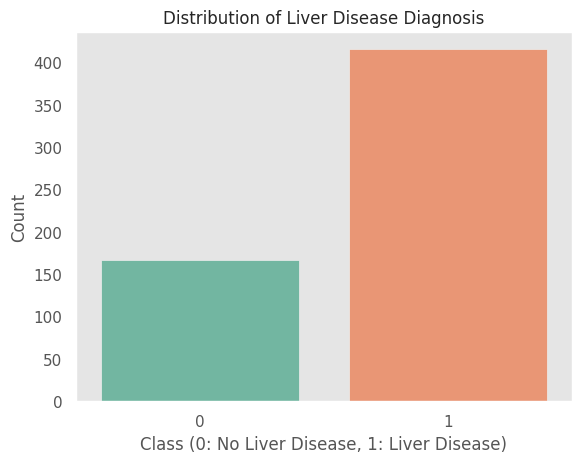

Number of patients diagnosed with liver disease:  416
Number of patients not diagnosed with liver disease:  167


In [50]:
sns.countplot(data=liver_df, x='Class', palette='Set2')
sns.set(style="whitegrid")
plt.title('Distribution of Liver Disease Diagnosis')
plt.xlabel('Class (0: No Liver Disease, 1: Liver Disease)')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Count the number of patients diagnosed with liver disease and those not diagnosed
LD, NLD = liver_df['Class'].value_counts()
print('Number of patients diagnosed with liver disease: ', LD)
print('Number of patients not diagnosed with liver disease: ', NLD)

Number of patients that are male:  441
Number of patients that are female:  142


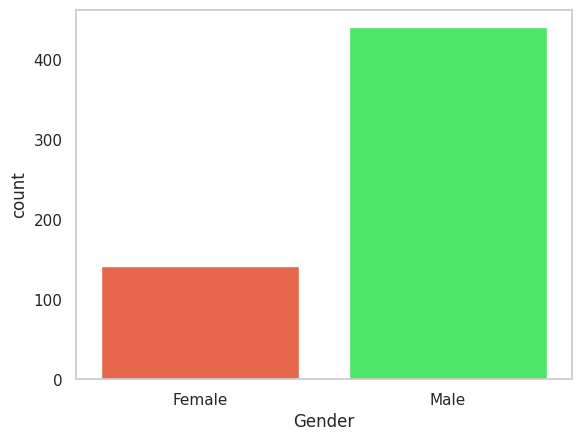

In [51]:
# Plotting the Number of Male and Female patients
sns.countplot(data=liver_df, x = 'Gender', label='Count',palette=["#FF5733", "#33FF57"])
sns.set(style="whitegrid")
plt.grid(False)


M, F = liver_df['Gender'].value_counts()
print('Number of patients that are male: ',M)
print('Number of patients that are female: ',F)

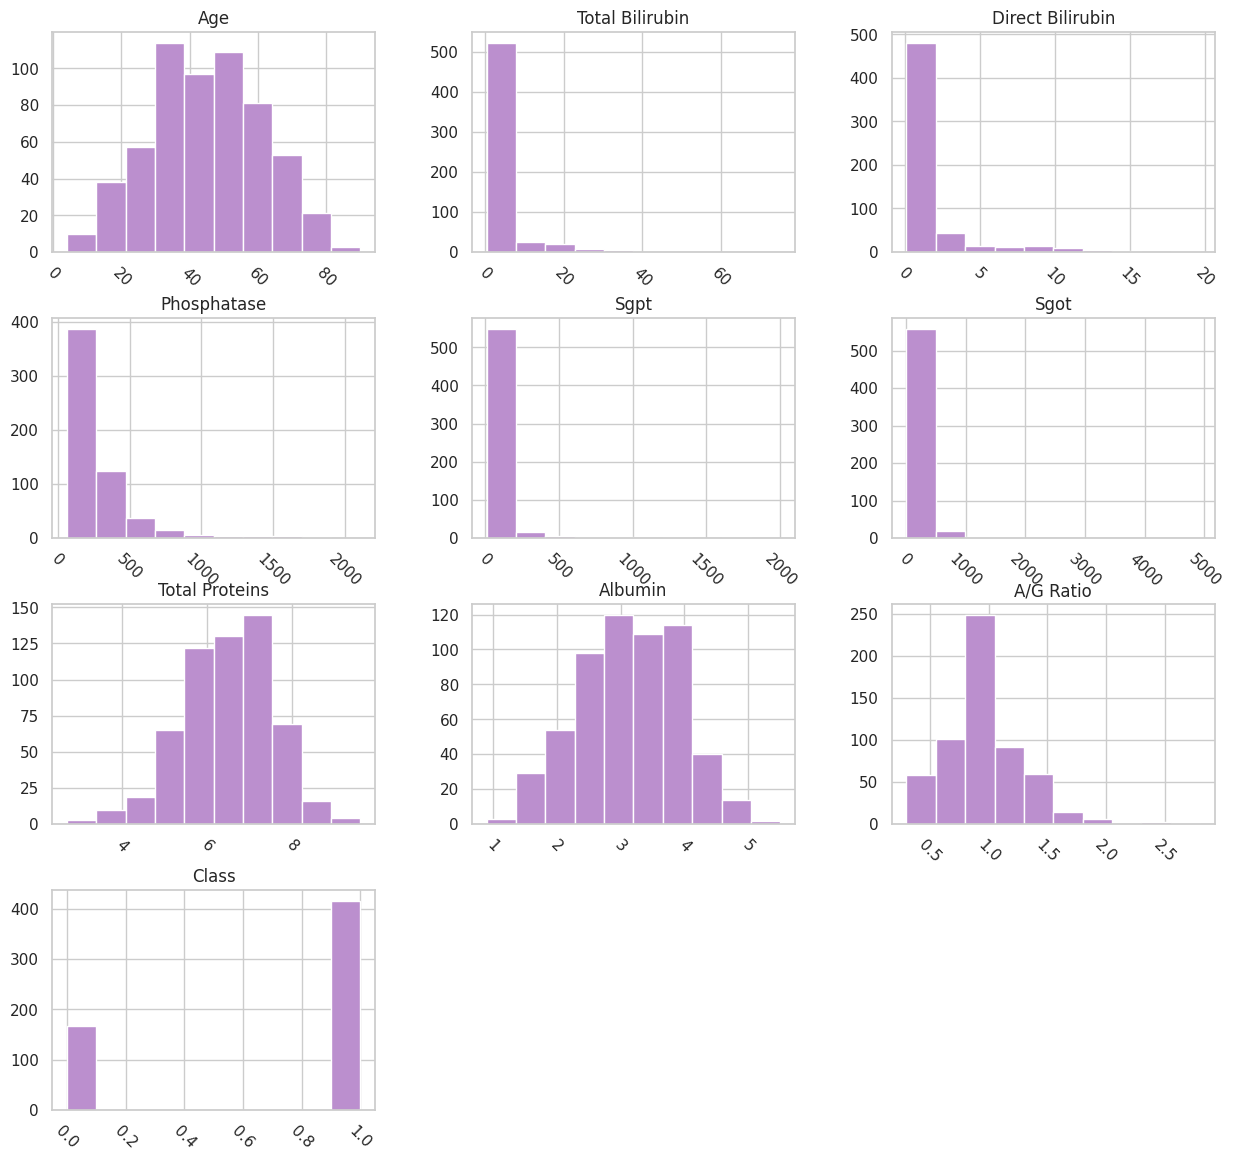

In [52]:
# Cheching for distribution

liver_df.hist(figsize=(15, 14), xrot=-45, bins=10, color='#BB8FCE')
plt.show()

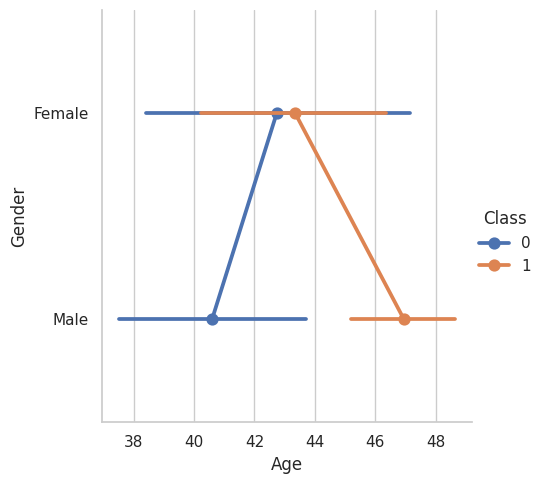

In [53]:
sns.catplot(x="Age", y="Gender", hue="Class", data=liver_df, kind="point")

In [54]:
# convert the gender to numeric values
print(liver_df['Gender'].unique())
liver_df1 = liver_df.copy()
liver_df1['Gender'] = liver_df1['Gender'].astype(str)
def convertgender(x):
    if x == 'Male':
        return 0
    else:
        return 1
liver_df1['Gender'] = liver_df1['Gender'].map(convertgender)
liver_df1.head()

['Female', 'Male']
Categories (2, object): ['Female' < 'Male']


,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
0,65,1,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62,0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62,0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58,0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72,0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [55]:
liver_df1.corr()

#Positive correlations -> one feature increases other also increases
#Negative correlations -> one feature increases other descreases
#close to 0 -> weak relationship

,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
Age,1.000000,-0.056560,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216089,0.137351
Gender,-0.056560,1.000000,-0.089291,-0.100436,0.027496,-0.082332,-0.080336,0.089121,0.093799,0.003404,-0.082416
Total Bilirubin,0.011763,-0.089291,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206159,0.220208
Direct Bilirubin,0.007529,-0.100436,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200004,0.246046
Phosphatase,0.080425,0.027496,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.233960,0.184866
Sgpt,-0.086883,-0.082332,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002374,0.163416
Sgot,-0.019910,-0.080336,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070024,0.151934
Total Proteins,-0.187461,0.089121,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.233904,-0.035008
Albumin,-0.265924,0.093799,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.686322,-0.161388
A/G Ratio,-0.216089,0.003404,-0.206159,-0.200004,-0.233960,-0.002374,-0.070024,0.233904,0.686322,1.000000,-0.162319


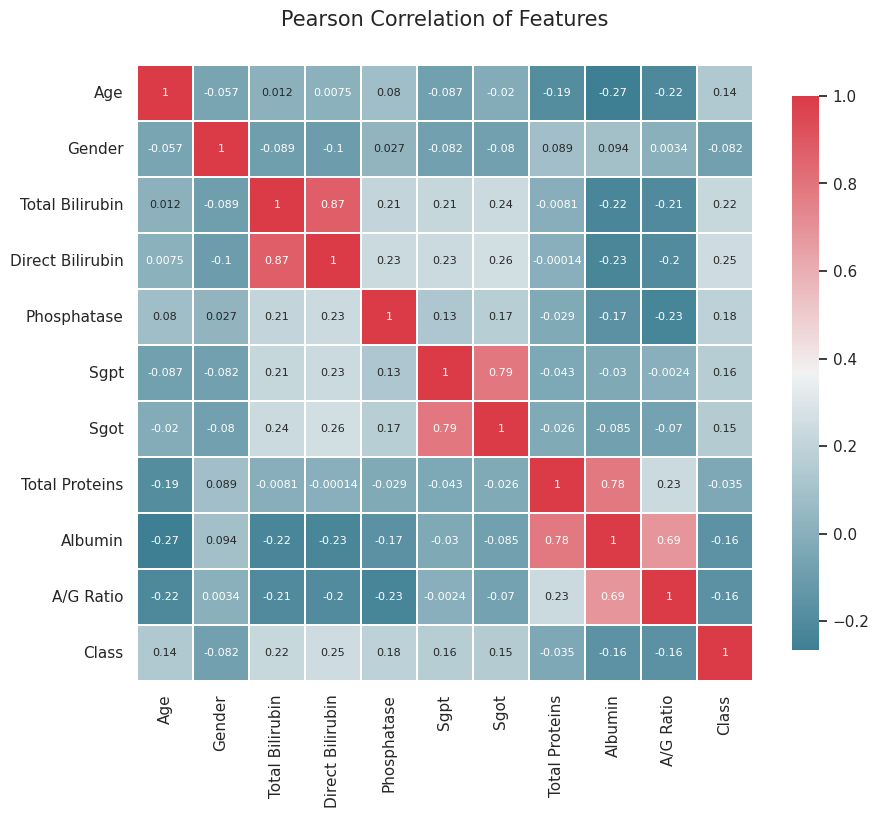

In [57]:
# Heatmap on correlation
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(10, 8))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(
        liver_df1.corr(),
        cmap = colormap,
        square=True,
        cbar_kws={'shrink':.9 },
        ax=ax,
        annot=True,
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':8 }
    )

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(liver_df1)

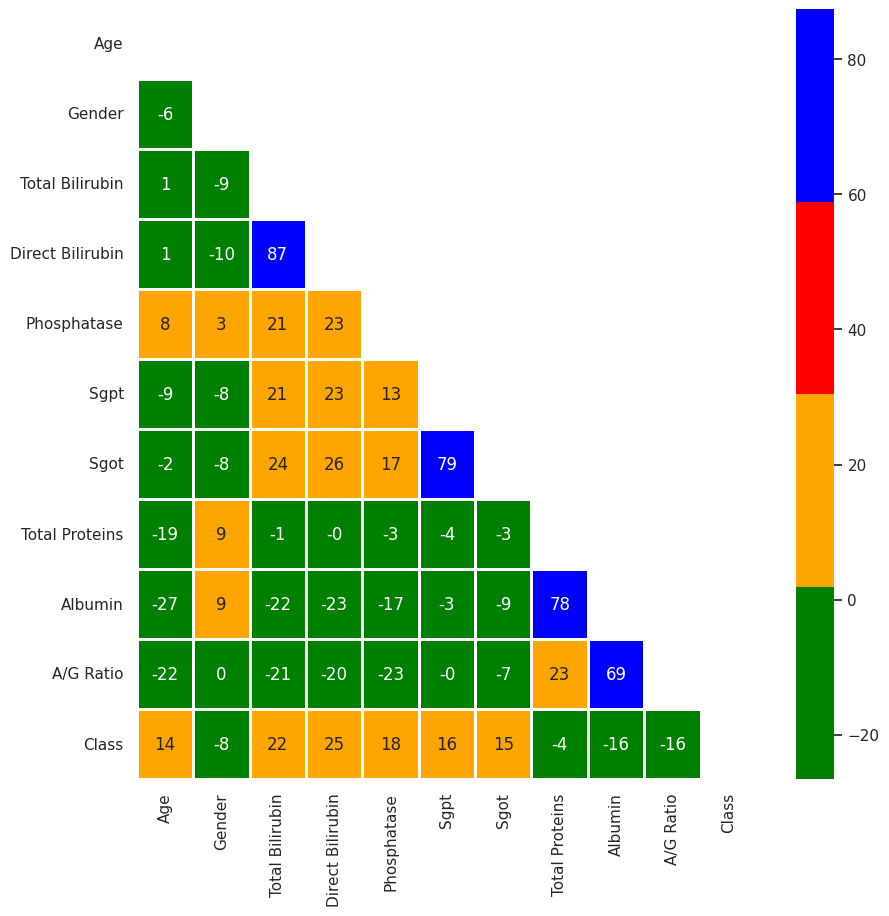

In [58]:
# triangular heatmaps
mask = np.triu(np.ones_like(liver_df1.corr()))
plt.figure(figsize=(10, 10))
with sns.axes_style('white'):
  ax= sns.heatmap(liver_df1.corr()*100, mask=mask, fmt=".0f", annot=True, lw =1,  cmap=ListedColormap(['green','orange','red','blue']))